<a href="https://colab.research.google.com/github/Torbey/JProg/blob/master/Monte_Carlo_Markowitz_Portfolio_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import relevant libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

# stock = ['BAC', 'GS', 'JPM', 'MS']
stock = ['C', 'AMD', 'XOM', 'SBUX', 'CVS']
data = web.DataReader(stock,data_source="yahoo",start='10/01/2017',end='12/06/2019')['Adj Close']


In [0]:
#Arrange the data in ascending order
data = data.sort_index()
#print(data.round(2))

In [0]:
stock_ret = data/data.shift(1)-1 #can also say data.per_change()
print(stock_ret)

Symbols          AMD         C       CVS      SBUX       XOM
Date                                                        
2017-10-02       NaN       NaN       NaN       NaN       NaN
2017-10-03  0.055862  0.004471  0.001733  0.003345  0.001593
2017-10-04 -0.008197 -0.000944 -0.010382 -0.001111  0.000367
2017-10-05  0.002254  0.022414  0.010366  0.012423  0.002812
2017-10-06 -0.008246 -0.001057 -0.049197  0.010440 -0.003779
2017-10-09  0.018141 -0.003305 -0.034061 -0.002719  0.003916
2017-10-10  0.017075 -0.002786  0.005518  0.007270  0.002804
2017-10-11  0.013139 -0.003192 -0.010842  0.003970  0.004133
2017-10-12  0.023055 -0.034294 -0.001624  0.005931 -0.002058
2017-10-13  0.001408 -0.003593 -0.015993 -0.004467 -0.000243
2017-10-16  0.002813 -0.004715 -0.002204 -0.014537  0.004854
2017-10-17 -0.007013  0.005852  0.002623 -0.007285  0.001812
2017-10-18 -0.006356  0.012883  0.020240  0.012842 -0.002411
2017-10-19 -0.008529 -0.003282  0.007152  0.003442 -0.000242
2017-10-20 -0.010036  0.

In [0]:
#Compute stock returns and print the returns in percentage format
stock_ret = data.pct_change()
#print(stock_ret.round(4)*100)
#annualize the returns
def annualize_return(percent: float, months: int) -> float:
  pass

In [0]:
#Calculate mean returns and covariances of all four the stocks
mean_returns = stock_ret.mean()
cov_matrix = stock_ret.cov()
print(mean_returns)
print(cov_matrix)

Symbols
AMD     0.002354
C       0.000076
CVS    -0.000210
SBUX    0.001165
XOM    -0.000048
dtype: float64
Symbols       AMD         C       CVS      SBUX       XOM
Symbols                                                  
AMD      0.001429  0.000196  0.000155  0.000126  0.000147
C        0.000196  0.000229  0.000092  0.000060  0.000095
CVS      0.000155  0.000092  0.000324  0.000050  0.000066
SBUX     0.000126  0.000060  0.000050  0.000181  0.000050
XOM      0.000147  0.000095  0.000066  0.000050  0.000145


In [0]:
#Set the number of iterations to 100000 and define an array to hold the simulation results; initially set to all zeros
num_iterations = 100000
simulation_res = np.zeros((4+len(stock)-1,num_iterations))

In [0]:
for i in range(num_iterations):
    #Select random weights and normalize to set the sum to 1
    weights = np.array(np.random.random(len(stock)))
    weights /= np.sum(weights)
    #Calculate the return and standard deviation for every step
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
    #Store all the results in a defined array
    simulation_res[0,i] = portfolio_return
    simulation_res[1,i] = portfolio_std_dev
    #Calculate Sharpe ratio and store it in the array
    simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
    #Save the weights in the array
    for j in range(len(weights)):
        simulation_res[j+3,i] = weights[j]

In [0]:
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe',stock[0],stock[1],stock[2],stock[3],stock[4]])
print(sim_frame.head (5))
print(sim_frame.tail (5))

        ret     stdev    sharpe  ...       XOM      SBUX       CVS
0  0.000433  0.013689  0.031652  ...  0.203907  0.055503  0.098820
1  0.000354  0.012323  0.028695  ...  0.277996  0.076329  0.384557
2  0.000575  0.010945  0.052536  ...  0.062207  0.315386  0.330785
3  0.000796  0.014067  0.056618  ...  0.161186  0.222605  0.214528
4  0.000901  0.016581  0.054363  ...  0.192774  0.136300  0.272043

[5 rows x 8 columns]
            ret     stdev    sharpe  ...       XOM      SBUX       CVS
99995  0.001150  0.016353  0.070297  ...  0.106775  0.337975  0.082766
99996  0.000820  0.013109  0.062524  ...  0.019242  0.334782  0.087390
99997  0.000661  0.014817  0.044590  ...  0.264286  0.097300  0.217869
99998  0.000289  0.011354  0.025410  ...  0.134823  0.104234  0.358337
99999  0.001289  0.017522  0.073571  ...  0.164136  0.391898  0.046891

[5 rows x 8 columns]


In [0]:
#Spot the position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]
#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
print("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print("The portfolio for min risk:\n", min_std)

The portfolio for max Sharpe Ratio:
 ret       0.001371
stdev     0.014952
sharpe    0.091670
C         0.240770
AMD       0.033726
XOM       0.029799
SBUX      0.692909
CVS       0.002796
Name: 28204, dtype: float64
The portfolio for min risk:
 ret       0.000320
stdev     0.009855
sharpe    0.032426
C         0.000353
AMD       0.132560
XOM       0.147456
SBUX      0.308209
CVS       0.411421
Name: 45099, dtype: float64


0.010840252786998085
<class 'pandas.core.series.Series'>

0.03691110450923694
<class 'pandas.core.series.Series'>




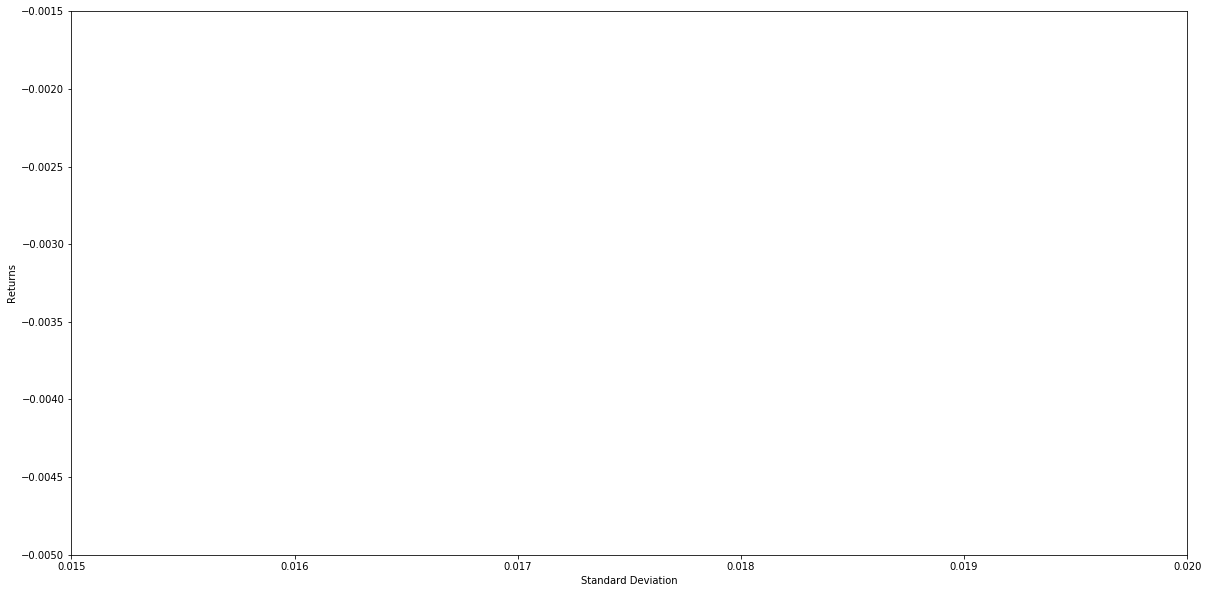

In [0]:
# Increase the Size of the Plot
#plt.rcParams["figure.figsize"] = (20,10)

#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
# plt.ylim(0,.003)
# plt.xlim(0.0075,0.012)
# print()
# print()
minstd = min_std*1.1
maxstd = sim_frame.iloc[sim_frame['stdev'].idxmax()]*1.1
# print(str(minstd), " ", str(maxstd))
# print()
# print()

print(minstd.loc['stdev'])
print(type(minstd))
print()
print(maxstd.loc['stdev'])
print(type(maxstd))
# plt.ylim(-.005,-.0015)
# plt.xlim(.015,.02)
print()
print()
plt.ylim(-.005,-.0015)
plt.xlim(.015,.02)
# plt.xlim(minstd.loc['stdev']*1.1,maxstd.loc['stdev']*1.1)
#Plot a red star to highlight position of the portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=300)
#Plot a blue star to highlight position of the portfolio with minimum Variance
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=300)
plt.show()

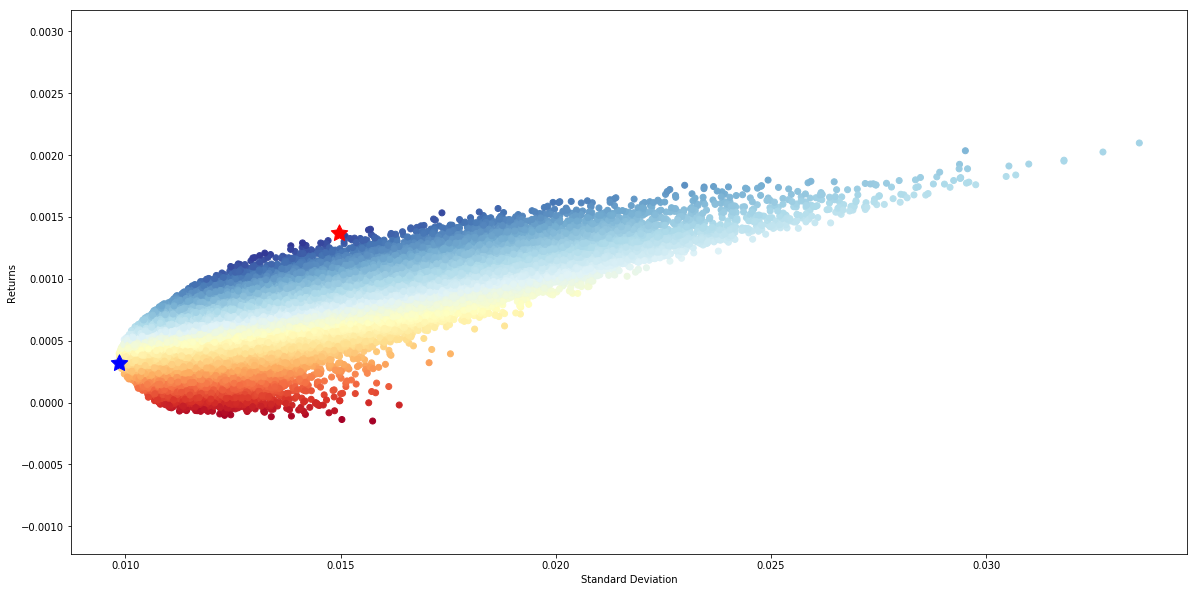

In [0]:
# Increase the Size of the Plot
plt.rcParams["figure.figsize"] = (20,10)

#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

minret = sim_frame['ret'].min(axis=0)
maxret = sim_frame['ret'].max(axis=0)

minstd = sim_frame['stdev'].min(axis=0)
maxstd = sim_frame['stdev'].max(axis=0)

adj_ret_coeff = abs((coeff_maxret-coeff_minret))*0.075
adj_std_coeff = abs((coeff_minstd-coeff_maxstd))*0.075

#print("{}, {}, {}, {}".format(coeff_maxret, coeff_maxstd, coeff_minret, coeff_minstd))

plt.ylim(minret-adj_ret_coeff,maxret+adj_ret_coeff)
plt.xlim(minstd-adj_std_coeff,maxstd+adj_std_coeff)

#Red Star : Maximum Sharpe Ratio Portfolio
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=300)
#Blue Star: Minimum Variance Portfolio
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=300)

plt.show()